#### In this exercise, you will build a convolutional neural network (CNN) to classify handwritten digits from the MNIST dataset. The steps to build a CNN classifier are outlined in section 20.15 of the Machine Learning with Python Cookbook, but keep in mind that your code may need to be modified depending on your version of Keras.

Naturally, it didn't work in Jupyter. After many attempts to update the environment and packages, the kernel died each time I tried to initialize the neural network, so I had to switch to Google Colab.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


#### Load the MNIST data set.

In [2]:
K.set_image_data_format("channels_first")
channels = 1
height = 28
width = 28
# Load data and target from MNIST data
(data_train, target_train), (data_test, target_test) = mnist.load_data()

Of course, the Channels first layout caused problems, but it seems that the GPU accelerator can handle it, for no accountable reason.

In [3]:
print(data_train.shape)
print(target_train.shape)

(60000, 28, 28)
(60000,)


#### Display the first five images in the training data set (see section 8.1 in the Machine Learning with Python Cookbook). Compare these to the first five training labels.

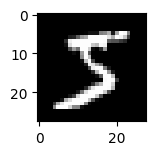

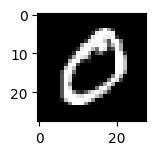

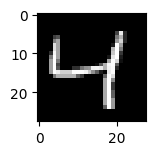

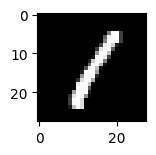

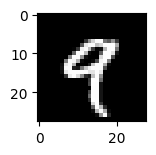

In [4]:
for i in range(5):  
    plt.subplot(330 + 1 + i)
    plt.imshow(data_train[i], cmap=plt.get_cmap('gray'))
    plt.show()

In [5]:
print(target_train[:5])

[5 0 4 1 9]


Exactly on target! 5 for 5!

#### Build and train a Keras CNN classifier on the MNIST training set.

In [6]:
# Reshape training image data into features
data_train = data_train.reshape(data_train.shape[0], channels, height, width)
# Reshape test image data into features
data_test = data_test.reshape(data_test.shape[0], channels, height, width)

In [7]:
# Rescale pixel intensity to between 0 and 1
features_train = data_train / 255
features_test = data_test / 255
# One-hot encode target
target_train = np_utils.to_categorical(target_train)
target_test = np_utils.to_categorical(target_test)
number_of_classes = target_test.shape[1]
print(number_of_classes)

10


Well, these are new functions. Still unclear to me why we needed to convert the target to features, however.

In [8]:
# Start neural network
network = Sequential()

In [9]:
# Add convolutional layer with 64 filters, a 5x5 window, and ReLU activation function
network.add(Conv2D(filters=64,
   kernel_size=(5, 5),
   input_shape=(channels, width, height),
   activation='relu'))

In [10]:
# Add max pooling layer with a 2x2 window
network.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
network.add(Dropout(0.5))

# Add layer to flatten input
network.add(Flatten())

Some of these parameters aren't clear why they were chosen- in particular why is the first dropout set at .5 and not .2 like we were told the first one should be?

In [11]:
# # Add fully connected layer of 128 units with a ReLU activation function
network.add(Dense(128, activation="relu"))

# Add dropout layer
network.add(Dropout(0.5))

# Add fully connected layer with a softmax activation function
network.add(Dense(number_of_classes, activation="softmax"))

In [12]:
network.compile(loss="categorical_crossentropy", # Cross-entropy
optimizer="rmsprop", # Root Mean Square Propagation
metrics=["accuracy"]) # Accuracy performance metric

In [13]:
# Train neural network
history=network.fit(features_train, target_train, epochs=3, verbose=0, batch_size=1000, validation_data=(features_test, target_test))

I didn't actually use the history to hypertune the model, and I also am suspicious as to how we were allowed to use the test set in the validation. That shouldn't be allowed! Total snooping.

In any case, let's see what the prediction yields:

In [14]:
train_pred=network.predict (features_train)

1875/1875 [==============================] - 7s 3ms/step


In [15]:
train_pred

array([[6.20223045e-06, 7.89730693e-05, 4.63080760e-05, ...,
        8.35006940e-05, 2.62643734e-04, 8.15334279e-05],
       [9.99794185e-01, 3.93894538e-07, 3.63102845e-05, ...,
        4.85353439e-06, 9.57522570e-06, 1.19170431e-06],
       [2.74749018e-05, 9.83971404e-04, 6.09397248e-04, ...,
        5.91068470e-04, 2.41608475e-04, 2.92089046e-03],
       ...,
       [1.26736381e-07, 5.78320339e-07, 1.34240175e-08, ...,
        1.28867555e-07, 9.74589930e-05, 6.55117256e-05],
       [5.36062580e-04, 1.15104967e-05, 1.37425057e-04, ...,
        1.17614161e-06, 2.76952669e-05, 5.55742963e-06],
       [7.95675965e-04, 1.67748512e-05, 2.81194894e-04, ...,
        2.37593747e-04, 9.93203044e-01, 3.69447493e-03]], dtype=float32)

What's that? Oh, it's the probability of matching the features of the target- so now, the question is how to extract the actual value predicted from that- stay tuned!

#### Report the test accuracy of your model.

In [16]:
loss, accuracy=network.evaluate(features_test, target_test)
print(accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.0722 - accuracy: 0.9778
0.9778000116348267


That's pretty good! Maybe too good, as I would wonder...

In [17]:
target_pred=network.predict(features_test)

313/313 [==============================] - 1s 2ms/step


In [18]:
targetpredround=np.around(target_pred)
targetpredround

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

I thought I needed to do this to get the actual number, but it turns out that I don't.

In [19]:
predarray=list()
for x in range(len(target_test)):
  predarray.append(np.argmax(targetpredround[x]))


In [20]:
targetarray=list()
for x in range(len(target_test)):
  targetarray.append(np.argmax(target_test[x]))

In [21]:
print(len(predarray))

10000


In [22]:
print(len(targetarray))

10000


I was just checking. Looks good. Now let's see the correspondence as a matrix:

#### Display a confusion matrix on the test set classifications.

In [23]:
from sklearn import metrics
print(metrics.multilabel_confusion_matrix(targetarray,predarray))

[[[8915  105]
  [   8  972]]

 [[8853   12]
  [  14 1121]]

 [[8937   31]
  [  29 1003]]

 [[8971   19]
  [  24  986]]

 [[9005   13]
  [  19  963]]

 [[9102    6]
  [  26  866]]

 [[9018   24]
  [  14  944]]

 [[8950   22]
  [  32  996]]

 [[9011   15]
  [  51  923]]

 [[8980   11]
  [  41  968]]]


That's cool, but not exactly what I wanted: that shows for each character what the confusion matrix was, but I'm interested in a single matrix with all 10 digits laid out actual vs. predicted.

In [24]:
metrics.confusion_matrix(targetarray,predarray)

array([[ 972,    0,    1,    0,    0,    0,    5,    1,    1,    0],
       [   9, 1121,    1,    1,    0,    0,    2,    0,    1,    0],
       [  14,    1, 1003,    0,    1,    0,    1,    8,    4,    0],
       [   8,    0,    7,  986,    0,    1,    0,    5,    3,    0],
       [   5,    0,    1,    0,  963,    0,    4,    1,    2,    6],
       [  10,    0,    0,    8,    0,  866,    5,    1,    2,    0],
       [   8,    3,    0,    0,    2,    1,  944,    0,    0,    0],
       [  10,    3,   13,    3,    0,    0,    0,  996,    1,    2],
       [  24,    0,    7,    3,    5,    1,    6,    2,  923,    3],
       [  17,    5,    1,    4,    5,    3,    1,    4,    1,  968]])

Yes it's pretty amazing. 

#### Summarize your results.

Well it was a great model- with a batch size of 1000 and three epochs. For a close examination of the results- it seems that the model had some trouble with zero (I think that's the first column) but it was still not a perfect analyzer. Perhaps with further tuning it could be improved yet further!